In [1]:
#Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
#Score: 0.157

import numpy as np
import pandas as pd
from fancyimpute import KNN, SimpleFill
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import csv
import os
import xgboost
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Load the dataset
def load_data():
    train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
    test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
    
    return train_df, test_df


train_df, test_df = load_data()
y_train = train_df['SalePrice']
train_df.drop(['SalePrice'], axis=1, inplace = True)

test_ids = test_df['Id'].values

Using TensorFlow backend.


PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
                 ...   
HeatingQC      0.000000
SaleType       0.000000
TotalBsmtSF    0.000000
BsmtUnfSF      0.000000
Id             0.000000
Length: 80, dtype: float64


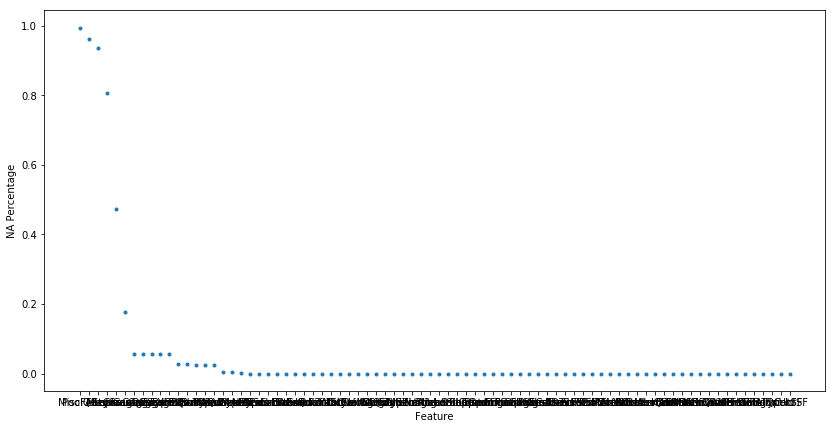

In [2]:
#EDA

#Remove features with NA percentage greater than 0.4
nan_df = train_df.isnull().sum()/len(train_df)

print(nan_df.sort_values()[::-1])

plt.figure(figsize=(14, 7))
plt.plot(nan_df.sort_values()[::-1], '.')
plt.xlabel('Feature')
plt.ylabel('NA Percentage')
plt.show()


train_df = train_df[[index for index, value in nan_df.items() if value < 0.4]]
test_df = test_df[[index for index, value in nan_df.items() if value < 0.4]]


In [3]:

#Identify the different types of variables
year_vars = [v for v in train_df.columns if 'Yr' in v or 'Year' in v]

categorical_vars = [v for v in train_df.columns if train_df[v].dtype == 'O']

discrete_vars = [
    v for v in train_df.columns if v not in categorical_vars and v not in year_vars and len(train_df[v].unique()) < 15
]

continuous_vars = [
    v for v in train_df.columns if v not in categorical_vars and v not in year_vars and v not in discrete_vars and v not in ['Id', 'SalePrice']
]

numerical_vars = continuous_vars + discrete_vars + year_vars

print('Nº Continuous variables: {}'.format(len(continuous_vars)))
print('Nº of Discrete variables: {}'.format(len(discrete_vars)))
print('Nº of Categorical variables: {}'.format(len(categorical_vars)))

print('Nº of variables with Year information: {}'.format(len(year_vars)))


Nº Continuous variables: 19
Nº of Discrete variables: 13
Nº of Categorical variables: 38
Nº of variables with Year information: 4


In [4]:

#Fill NA in numerical variables
#use the 3 closest instances for data imputation

train_df.loc[:,continuous_vars] = KNN(k=5).fit_transform(train_df[continuous_vars])
train_df.loc[:,discrete_vars] = KNN(k=5).fit_transform(train_df[discrete_vars])
train_df.loc[:,year_vars] = KNN(k=5).fit_transform(train_df[year_vars])

test_df.loc[:,continuous_vars] = KNN(k=5).fit_transform(test_df[continuous_vars])
test_df.loc[:,discrete_vars] = KNN(k=5).fit_transform(test_df[discrete_vars])
test_df.loc[:,year_vars] = KNN(k=5).fit_transform(test_df[year_vars])


#Fill NA in categorical variables
#add the 'Missing' label to missing data

imputer = SimpleImputer(strategy='constant', fill_value = 'Missing')

imputer.fit(train_df[categorical_vars])
train_df[categorical_vars] = imputer.transform(train_df[categorical_vars])
test_df[categorical_vars] = imputer.transform(test_df[categorical_vars])


Imputing row 1/1460 with 0 missing, elapsed time: 0.592
Imputing row 101/1460 with 1 missing, elapsed time: 0.594
Imputing row 201/1460 with 0 missing, elapsed time: 0.596
Imputing row 301/1460 with 0 missing, elapsed time: 0.597
Imputing row 401/1460 with 0 missing, elapsed time: 0.599
Imputing row 501/1460 with 0 missing, elapsed time: 0.601
Imputing row 601/1460 with 0 missing, elapsed time: 0.602
Imputing row 701/1460 with 0 missing, elapsed time: 0.604
Imputing row 801/1460 with 0 missing, elapsed time: 0.606
Imputing row 901/1460 with 1 missing, elapsed time: 0.607
Imputing row 1001/1460 with 0 missing, elapsed time: 0.609
Imputing row 1101/1460 with 0 missing, elapsed time: 0.610
Imputing row 1201/1460 with 0 missing, elapsed time: 0.612
Imputing row 1301/1460 with 1 missing, elapsed time: 0.614
Imputing row 1401/1460 with 0 missing, elapsed time: 0.615


/opt/conda/lib/python3.6/site-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/1460 with 0 missing, elapsed time: 0.436
Imputing row 101/1460 with 0 missing, elapsed time: 0.437
Imputing row 201/1460 with 0 missing, elapsed time: 0.437
Imputing row 301/1460 with 0 missing, elapsed time: 0.438
Imputing row 401/1460 with 0 missing, elapsed time: 0.438
Imputing row 501/1460 with 0 missing, elapsed time: 0.438
Imputing row 601/1460 with 0 missing, elapsed time: 0.439
Imputing row 701/1460 with 0 missing, elapsed time: 0.439
Imputing row 801/1460 with 0 missing, elapsed time: 0.440
Imputing row 901/1460 with 0 missing, elapsed time: 0.440
Imputing row 1001/1460 with 0 missing, elapsed time: 0.441
Imputing row 1101/1460 with 0 missing, elapsed time: 0.441
Imputing row 1201/1460 with 0 missing, elapsed time: 0.441
Imputing row 1301/1460 with 0 missing, elapsed time: 0.442
Imputing row 1401/1460 with 0 missing, elapsed time: 0.442
Imputing row 1/1460 with 0 missing, elapsed time: 0.357
Imputing row 101/1460 with 0 missing, elapsed time: 0.359
Imputing row 

In [5]:
print("NA in Train dataset: ", train_df.isnull().sum().sum())
print("NA in Test dataset: ", test_df.isnull().sum().sum())

NA in Train dataset:  0
NA in Test dataset:  0


In [6]:
#Categorical Encoding: One Hot Enconding

encoder = OneHotEncoder(categories = 'auto', handle_unknown = 'ignore', sparse = False)
encoder.fit(train_df[categorical_vars])


train_df = pd.concat([train_df, pd.DataFrame(encoder.transform(train_df[categorical_vars]), columns = encoder.get_feature_names())], axis=1, sort=False)
test_df = pd.concat([test_df, pd.DataFrame(encoder.transform(test_df[categorical_vars]), columns = encoder.get_feature_names())], axis=1, sort=False)

train_df.drop(categorical_vars, axis=1, inplace=True)
test_df.drop(categorical_vars, axis=1, inplace=True)


#Normalization

sc = StandardScaler()
sc.fit(train_df[numerical_vars])
train_df[numerical_vars] = sc.transform(train_df[numerical_vars])
test_df[numerical_vars] = sc.transform(test_df[numerical_vars])



In [7]:
#Feature Selection - Correlation

print("Number of Initial Features: ", len(train_df.columns))
train_df['SalePrice'] = y_train
cor = train_df.corr()

#plt.figure(figsize=(12,10))
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()

cor_price = abs(cor['SalePrice'])
relevant_features = cor_price[cor_price>0.4].index
relevant_features = relevant_features.drop(['SalePrice'])  

print('Relevant Features ({}): {}'.format(len(relevant_features), relevant_features))


train_df = train_df.loc[:, relevant_features]
test_df = test_df.loc[:, relevant_features]


Number of Initial Features:  282
Relevant Features (26): Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'x7_NridgHt', 'x17_Ex',
       'x17_Gd', 'x17_TA', 'x19_PConc', 'x20_Ex', 'x20_TA', 'x23_GLQ',
       'x26_Ex', 'x29_Ex', 'x29_TA', 'x32_Fin', 'x32_Unf'],
      dtype='object')


In [8]:
#XGBOOST

parameters = {
    'max_depth': [5, 10],
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.001, 0.005]
}

#Cross Validation
grid_search = GridSearchCV(
    estimator=xgboost.XGBRegressor(),
    param_grid=parameters,
    n_jobs = 10,
    cv = 10
)


grid_search.fit(train_df, y_train)
print("Best Parms", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_




/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Parms {'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 1000}
Best Score:  0.8602312647577743


In [9]:
results = best_model.predict(test_df)

#export the results
with open('test_results.csv', 'w') as writeFile:
    
    writer = csv.writer(writeFile)
    writer.writerow(['Id', 'SalePrice'])
    
    for ind, sample in enumerate(results):
        writer.writerow([test_ids[ind], sample])

writeFile.close()